/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

Episode: 1, Reward: 27.0, Epsilon: 0.9950, Avg100: 27.00
Episode: 2, Reward: 26.0, Epsilon: 0.9900, Avg100: 26.50
Episode: 3, Reward: 12.0, Epsilon: 0.9851, Avg100: 21.67
Episode: 4, Reward: 11.0, Epsilon: 0.9801, Avg100: 19.00
Episode: 5, Reward: 12.0, Epsilon: 0.9752, Avg100: 17.60


I0000 00:00:1750191159.127027      59 service.cc:148] XLA service 0x7cad04003a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750191159.127707      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750191159.198288      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750191159.380459      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode: 6, Reward: 11.0, Epsilon: 0.9704, Avg100: 16.50
Episode: 7, Reward: 11.0, Epsilon: 0.9655, Avg100: 15.71
Episode: 8, Reward: 22.0, Epsilon: 0.9607, Avg100: 16.50
Episode: 9, Reward: 21.0, Epsilon: 0.9559, Avg100: 17.00
Episode: 10, Reward: 35.0, Epsilon: 0.9511, Avg100: 18.80
Episode: 11, Reward: 23.0, Epsilon: 0.9464, Avg100: 19.18
Episode: 12, Reward: 13.0, Epsilon: 0.9416, Avg100: 18.67
Episode: 13, Reward: 79.0, Epsilon: 0.9369, Avg100: 23.31
Episode: 14, Reward: 23.0, Epsilon: 0.9322, Avg100: 23.29
Episode: 15, Reward: 16.0, Epsilon: 0.9276, Avg100: 22.80
Episode: 16, Reward: 24.0, Epsilon: 0.9229, Avg100: 22.88
Episode: 17, Reward: 18.0, Epsilon: 0.9183, Avg100: 22.59
Episode: 18, Reward: 10.0, Epsilon: 0.9137, Avg100: 21.89
Episode: 19, Reward: 20.0, Epsilon: 0.9092, Avg100: 21.79
Episode: 20, Reward: 42.0, Epsilon: 0.9046, Avg100: 22.80
Episode: 21, Reward: 20.0, Epsilon: 0.9001, Avg100: 22.67
Episode: 22, Reward: 15.0, Epsilon: 0.8956, Avg100: 22.32
Episode: 23, Rewar

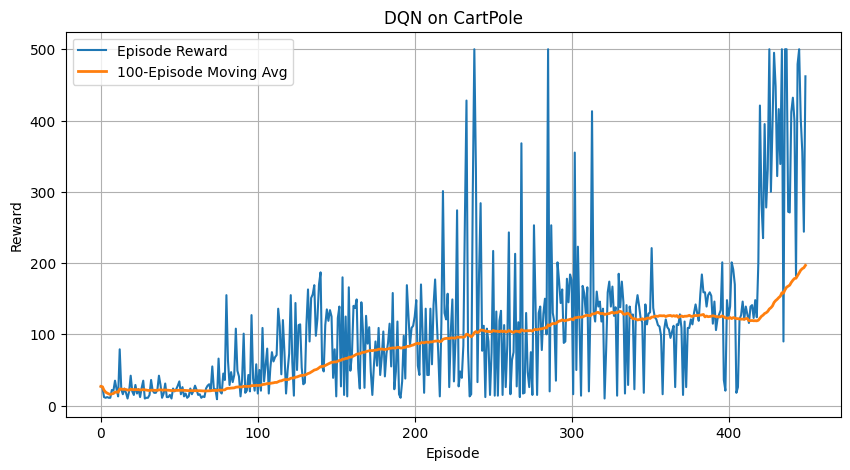

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

REPLAY_MEMORY_SIZE = 50_000
MIN_REPLAY_MEMORY_SIZE = 1000
MINIBATCH_SIZE = 64
DISCOUNT = 0.99
UPDATE_TARGET_EVERY = 5
EPISODES = 500
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01
LEARNING_RATE = 0.001

env = gym.make("CartPole-v1")
OBSERVATION_SPACE_VALUES = env.observation_space.shape[0]
ACTION_SPACE_SIZE = env.action_space.n

class DQNAgent:
    def __init__(self):
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()
        model.add(Dense(64, input_shape=(OBSERVATION_SPACE_VALUES,), activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(ACTION_SPACE_SIZE, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=LEARNING_RATE), metrics=["accuracy"])
        return model

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape), verbose=0)

    def train(self, terminal_state):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states, verbose=0)

        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)

        X, Y = [], []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            X.append(current_state)
            Y.append(current_qs)

        self.model.fit(np.array(X), np.array(Y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

        if terminal_state:
            self.target_update_counter += 1

        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0


agent = DQNAgent()
epsilon = 1.0
rewards = []
moving_avg = []

for episode in range(EPISODES):
    current_state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(agent.get_qs(current_state)[0])
        else:
            action = np.random.randint(0, ACTION_SPACE_SIZE)

        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done)

        current_state = new_state
        total_reward += reward

    rewards.append(total_reward)
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

    avg_reward = np.mean(rewards[-100:])
    moving_avg.append(avg_reward)

    print(f"Episode: {episode + 1}, Reward: {total_reward}, Epsilon: {epsilon:.4f}, Avg100: {avg_reward:.2f}")

    if avg_reward >= 195:
        print(f"\nEnvironment solved in {episode+1} episodes!")
        break


plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Episode Reward")
plt.plot(moving_avg, label="100-Episode Moving Avg", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN on CartPole")
plt.legend()
plt.grid(True)
plt.show()
